In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
from sklearn.decomposition import PCA
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from fiona.crs import from_epsg
import os
from astropy.stats import median_absolute_deviation
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import cross_val_score
from factor_analyzer import FactorAnalyzer
from sklearn import  preprocessing
import pysal

Populating the interactive namespace from numpy and matplotlib


C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [210]:
data = pd.read_csv('DATA/bk1516diff.csv')

In [211]:
data.head()

,Unnamed: 0,GEOID,pickups_intract,NYPDviolation,NYPDmisdemeanor,NYPDfelony,units,CUR_FV_T_perSQFT_x,NEW_FV_T_perSQFT_x,HousepriceDiffC1,CUR_FV_T_perSQFT_y,NEW_FV_T_perSQFT_y,HousepriceDiffC2,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16
0,1,36047000100,102138.80700,19.0,37,26,106.0,1190.616338,1459.290687,268.674349,1363.877877,1585.105886,221.228009,48962.61730,87192,0.5344,31.880809,0.044279,0.000000
1,2,36047000200,21497.86679,20.0,125,84,NaN,243.786509,313.939797,70.153287,305.963908,367.481876,61.517968,14572.93623,48393,0.4195,38.851351,0.070218,0.006105
2,3,36047000301,96582.50072,10.0,56,46,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,51162.57739,112361,0.5882,32.719752,0.023952,0.003595
3,4,36047000501,39175.79425,8.0,25,17,62.0,NaN,NaN,0.000000,NaN,NaN,0.000000,145300.91520,124205,0.4928,29.035050,0.059278,0.004904
4,5,36047000502,45341.36746,19.0,63,38,NaN,1317.588974,1528.943303,211.354329,989.028877,1184.871247,195.842370,70038.71980,100805,0.5048,29.980013,0.057534,0.009077


In [212]:
data.units = data.units.replace(np.nan,0)

In [213]:
data = data.drop(['Unnamed: 0'],axis=1)

In [214]:
data.head(3)

,GEOID,pickups_intract,NYPDviolation,NYPDmisdemeanor,NYPDfelony,units,CUR_FV_T_perSQFT_x,NEW_FV_T_perSQFT_x,HousepriceDiffC1,CUR_FV_T_perSQFT_y,NEW_FV_T_perSQFT_y,HousepriceDiffC2,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16
0,36047000100,102138.80700,19.0,37,26,106.0,1190.616338,1459.290687,268.674349,1363.877877,1585.105886,221.228009,48962.61730,87192,0.5344,31.880809,0.044279,0.000000
1,36047000200,21497.86679,20.0,125,84,0.0,243.786509,313.939797,70.153287,305.963908,367.481876,61.517968,14572.93623,48393,0.4195,38.851351,0.070218,0.006105
2,36047000301,96582.50072,10.0,56,46,0.0,NaN,NaN,0.000000,NaN,NaN,0.000000,51162.57739,112361,0.5882,32.719752,0.023952,0.003595


In [215]:
TRACT = gpd.GeoDataFrame.from_file('DATA/gz_2010_36_140_00_500k/gz_2010_36_140_00_500k.shp')

In [216]:
TRACT.GEO_ID = TRACT.GEO_ID.str[9:]

In [217]:
data.GEOID = data.GEOID.astype('str')

In [218]:
data = pd.merge(TRACT,data,left_on='GEO_ID',right_on='GEOID')

In [219]:
data.TRACT = data.TRACT.astype('int64')

In [220]:
NTA = pd.read_csv('DATA/2010CensusTract_PUMA_NTA(1).csv')

In [221]:
NTA = NTA[NTA['Borough'] == 'Brooklyn']

In [222]:
data = pd.merge(data,NTA,left_on='TRACT',right_on='2010CensusTract')

In [223]:
data.groupby('PUMA').median()['pickups_intract'][4001]

50115.333734999993

In [224]:
def median_interpolation(data,columns):
    for column in columns:
        for i in range(len(data.index)):
            if np.isnan(data[column][i]):
                data[column][i] = data.groupby('PUMA').median()[column][data['PUMA'][i]] 
    return data

In [225]:
data.columns[9:26]

Index(['pickups_intract', 'NYPDviolation', 'NYPDmisdemeanor', 'NYPDfelony',
       'units', 'CUR_FV_T_perSQFT_x', 'NEW_FV_T_perSQFT_x', 'HousepriceDiffC1',
       'CUR_FV_T_perSQFT_y', 'NEW_FV_T_perSQFT_y', 'HousepriceDiffC2',
       'Pop_Den_16', 'Median_Household_Income_16', 'Gini_Index_16',
       'Ave_Commute_Min_16', 'Unemployed_rate_16', 'Moved_in_4years_16'],
      dtype='object')

In [226]:
data = median_interpolation(data,data.columns[9:26])

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [227]:
data.isnull().sum()

GEO_ID                        0
STATE                         0
COUNTY                        0
TRACT                         0
NAME                          0
LSAD                          0
CENSUSAREA                    0
geometry                      0
GEOID                         0
pickups_intract               0
NYPDviolation                 0
NYPDmisdemeanor               0
NYPDfelony                    0
units                         0
CUR_FV_T_perSQFT_x            0
NEW_FV_T_perSQFT_x            0
HousepriceDiffC1              0
CUR_FV_T_perSQFT_y            0
NEW_FV_T_perSQFT_y            0
HousepriceDiffC2              0
Pop_Den_16                    0
Median_Household_Income_16    0
Gini_Index_16                 0
Ave_Commute_Min_16            0
Unemployed_rate_16            0
Moved_in_4years_16            0
Borough                       0
2010CensusTract               0
PUMA                          0
NTA_Code                      0
NTA_Name                      0
dtype: i

## Normalization

In [228]:
data.columns[9:26]

Index(['pickups_intract', 'NYPDviolation', 'NYPDmisdemeanor', 'NYPDfelony',
       'units', 'CUR_FV_T_perSQFT_x', 'NEW_FV_T_perSQFT_x', 'HousepriceDiffC1',
       'CUR_FV_T_perSQFT_y', 'NEW_FV_T_perSQFT_y', 'HousepriceDiffC2',
       'Pop_Den_16', 'Median_Household_Income_16', 'Gini_Index_16',
       'Ave_Commute_Min_16', 'Unemployed_rate_16', 'Moved_in_4years_16'],
      dtype='object')

In [229]:
def norm(data,columns):
    for x in columns:
        data[x] = (data[x]-np.min(data[x]))/(np.max(data[x])-np.min(data[x]))
    return data

In [230]:
data = norm(data,data.columns[9:26])

In [231]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,pickups_intract,NYPDviolation,NYPDmisdemeanor,NYPDfelony,units,CUR_FV_T_perSQFT_x,NEW_FV_T_perSQFT_x,HousepriceDiffC1,CUR_FV_T_perSQFT_y,NEW_FV_T_perSQFT_y,HousepriceDiffC2,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
0,36047010400,36,047,10400,104,Tract,0.059,"POLYGON ((-74.01115399999999 40.637404, -74.01...",36047010400,0.019185,0.116564,0.118451,0.110075,0.0,0.24226,0.207946,0.146359,0.123972,0.139467,0.277246,0.618312,0.180679,0.659363,0.398564,0.122178,0.304749,Brooklyn,10400,4012,BK34,Sunset Park East


## Outliers

In [237]:

def clean(data,columns):
    for x in columns:
        #data= data[(np.abs(data[x]-np.median(data[x]))/(np.median(np.abs(data[x]-np.median(data[x])))/0.6745)) < 2.24]
        data = data[(data[x]<np.mean(data[x])+4*np.std(data[x]))&(data[x]>np.mean(data[x])-4*np.std(data[x]))]
    return data

In [238]:
data = clean(data,data.columns[9:26])

In [239]:
data.shape

(662, 31)

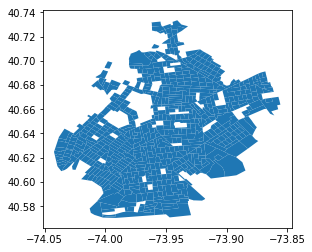

In [240]:
data.plot()

In [241]:
data.columns[9:26]

Index(['pickups_intract', 'NYPDviolation', 'NYPDmisdemeanor', 'NYPDfelony',
       'units', 'CUR_FV_T_perSQFT_x', 'NEW_FV_T_perSQFT_x', 'HousepriceDiffC1',
       'CUR_FV_T_perSQFT_y', 'NEW_FV_T_perSQFT_y', 'HousepriceDiffC2',
       'Pop_Den_16', 'Median_Household_Income_16', 'Gini_Index_16',
       'Ave_Commute_Min_16', 'Unemployed_rate_16', 'Moved_in_4years_16'],
      dtype='object')

## PCA

In [242]:
X_num = data[data.columns[9:26]].drop(['units','CUR_FV_T_perSQFT_x', 'NEW_FV_T_perSQFT_x', 'HousepriceDiffC1',
       'CUR_FV_T_perSQFT_y', 'NEW_FV_T_perSQFT_y', 'HousepriceDiffC2'],axis=1)
pca = PCA(0.90)
Xproj = pca.fit_transform(X_num)

In [243]:
pca.explained_variance_ratio_

array([ 0.36829375,  0.21082402,  0.14256356,  0.10986584,  0.05831223,
        0.04588564])

In [244]:
components_explanation = pd.DataFrame(pca.components_,columns = X_num.columns)
components_explanation

,pickups_intract,NYPDviolation,NYPDmisdemeanor,NYPDfelony,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16
0,0.034429,0.538161,0.266385,0.261188,0.566956,-0.408738,0.163644,0.096516,0.212659,0.013913
1,0.038894,-0.315501,-0.143848,-0.144958,0.598592,0.020942,0.092050,-0.679664,-0.167546,-0.001350
2,-0.122166,-0.222119,-0.180774,-0.187112,0.540846,0.155629,-0.393970,0.623139,-0.085698,0.021327
3,-0.230611,-0.377413,-0.243490,-0.247191,-0.077626,-0.643430,0.451737,0.207191,0.130076,-0.006701
4,0.159249,0.015351,-0.031540,-0.033951,0.125888,0.541600,0.738479,0.235443,0.030597,0.247703
5,0.053615,-0.098218,-0.106050,-0.112830,0.011841,0.115680,-0.197020,-0.139422,0.897804,0.292697


## FA

In [245]:
fa = FactorAnalyzer()

In [246]:
fa.analyze(X_num,5,rotation='varimax')

In [247]:
fa.get_communalities()

,Communalities
pickups_intract,0.394125
NYPDviolation,0.749171
NYPDmisdemeanor,0.987219
NYPDfelony,0.957446
Pop_Den_16,0.136461
Median_Household_Income_16,1.020269
Gini_Index_16,0.218097
Ave_Commute_Min_16,0.994824
Unemployed_rate_16,0.364532
Moved_in_4years_16,0.071707


In [248]:
fa.loadings

,Factor1,Factor2,Factor3,Factor4,Factor5
pickups_intract,-0.391498,0.407565,0.149938,0.228612,0.0
NYPDviolation,-0.784661,-0.121463,-0.311121,0.148084,0.0
NYPDmisdemeanor,-0.967836,0.001127,-0.224500,-0.010555,0.0
NYPDfelony,-0.955124,0.009742,-0.211949,-0.012951,0.0
Pop_Den_16,-0.190360,0.068654,-0.307974,0.025753,0.0
Median_Household_Income_16,0.158027,0.205589,0.965460,0.144628,0.0
Gini_Index_16,-0.077887,0.147762,-0.408610,0.152430,0.0
Ave_Commute_Min_16,-0.147889,-0.968950,0.134633,0.126346,0.0
Unemployed_rate_16,-0.304612,-0.186704,-0.364022,0.323067,0.0
Moved_in_4years_16,-0.000926,-0.003746,-0.017349,0.267191,0.0


In [249]:
fa.get_factor_variance()

,Factor1,Factor2,Factor3,Factor4,Factor5
SS Loadings,2.799867,1.223508,1.559462,0.311014,0.000000
Proportion Var,0.279987,0.122351,0.155946,0.031101,0.000000
Cumulative Var,0.279987,0.402337,0.558284,0.589385,0.589385


In [250]:
fa.loadings[np.abs(fa.loadings['Factor1'])>0.5]['Factor1']

NYPDviolation     -0.784661
NYPDmisdemeanor   -0.967836
NYPDfelony        -0.955124
Name: Factor1, dtype: float64

In [251]:
for column in fa.loadings:
    print(column+':\n')
    print(fa.loadings[np.abs(fa.loadings[column])>0.5][column])
    print('\n')

Factor1:

NYPDviolation     -0.784661
NYPDmisdemeanor   -0.967836
NYPDfelony        -0.955124
Name: Factor1, dtype: float64


Factor2:

Ave_Commute_Min_16   -0.96895
Name: Factor2, dtype: float64


Factor3:

Median_Household_Income_16    0.96546
Name: Factor3, dtype: float64


Factor4:

Series([], Name: Factor4, dtype: float64)


Factor5:

Series([], Name: Factor5, dtype: float64)




## Factor 1: Crime
## Factor 2: Income intergration and poverty level
## Factor 3: Traffic convenience
## Factor 4: New population

In [252]:
X_num.head(1)

,pickups_intract,NYPDviolation,NYPDmisdemeanor,NYPDfelony,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16
1,0.018984,0.09816,0.071754,0.059701,0.553791,0.169109,0.60298,0.483852,0.113104,0.06791


In [253]:
X_num.to_csv('X_num.csv')

In [254]:
X_num1 = pd.read_csv('X_num1.csv')

In [255]:
data = data.drop(list(X_num.columns),axis=1)

In [256]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,units,CUR_FV_T_perSQFT_x,NEW_FV_T_perSQFT_x,HousepriceDiffC1,CUR_FV_T_perSQFT_y,NEW_FV_T_perSQFT_y,HousepriceDiffC2,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name
1,36047010600,36,047,10600,106,Tract,0.058,"POLYGON ((-74.003838 40.637546, -74.00442 40.6...",36047010600,0.0,0.269671,0.24963,0.233976,0.108513,0.12222,0.25633,Brooklyn,10600,4012,BK34,Sunset Park East


In [257]:
data.index = range(len(data.index))

In [258]:
X_num1.columns = ['Crime','Income intergration and poverty level','Traffic convenience','New population']

In [259]:
for column in X_num1.columns:
    data[column] = X_num1[column]

In [260]:
columns = []
for column in data.columns:
    column = column.replace(' ','_' )
    columns.append(column)

In [261]:
data.columns = columns

In [262]:
data.head(1)

,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,CENSUSAREA,geometry,GEOID,units,CUR_FV_T_perSQFT_x,NEW_FV_T_perSQFT_x,HousepriceDiffC1,CUR_FV_T_perSQFT_y,NEW_FV_T_perSQFT_y,HousepriceDiffC2,Borough,2010CensusTract,PUMA,NTA_Code,NTA_Name,Crime,Income_intergration_and_poverty_level,Traffic_convenience,New_population
0,36047010600,36,047,10600,106,Tract,0.058,"POLYGON ((-74.003838 40.637546, -74.00442 40.6...",36047010600,0.0,0.269671,0.24963,0.233976,0.108513,0.12222,0.25633,Brooklyn,10600,4012,BK34,Sunset Park East,-0.207978,1.102963,0.017713,4.554116


In [264]:
#data.units[data.units > 0] =1

In [265]:
'NEW_FV_T_perSQFT_x~'+'+'.join(data.columns[-4:])

'NEW_FV_T_perSQFT_x~Crime+Income_intergration_and_poverty_level+Traffic_convenience+New_population'

In [182]:
lm_no_units = smf.ols(formula='HousepriceDiffC1~'+'+'.join(data.columns[-4:])
             ,data=data).fit()
lm_no_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       HousepriceDiffC1   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.850
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           2.12e-05
Time:                        16:29:38   Log-Likelihood:                 614.87
No. Observations:                 634   AIC:                            -1220.
Df Residuals:                     629   BIC:                            -1197.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2209      0.004     60.374      0.000       0.214       0.228
Crime                                    -0.0064      0.004     -1.710      0.088      -0.014       0.001
Income_intergration_and_poverty_level     0.0046      0.004      1.278      0.202      -0.002       0.012
Traffic_convenience                       0.0174      0.004      4.684      0.000       0.010       0.025
New_population                            0.0031      0.004      0.847      0.397      -0.004       0.010
==============================================================================
Omnibus:                      107.110   Durbin-Watson:                   1.412
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.770
Skew:                           1.029   Prob(JB):                     1.24e-40
Kurtosis:                       4.650   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
lm_with_units = smf.ols(formula='HousepriceDiffC1~C(units)+'+'+'.join(data.columns[-4:])
             ,data=data).fit()
lm_with_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       HousepriceDiffC1   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.657
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           4.10e-05
Time:                        16:29:38   Log-Likelihood:                 615.32
No. Observations:                 634   AIC:                            -1219.
Df Residuals:                     628   BIC:                            -1192.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2203      0.004     59.449      0.000       0.213       0.228
C(units)[T.1.0]                           0.0221      0.023      0.944      0.345      -0.024       0.068
Crime                                    -0.0062      0.004     -1.676      0.094      -0.014       0.001
Income_intergration_and_poverty_level     0.0047      0.004      1.305      0.192      -0.002       0.012
Traffic_convenience                       0.0172      0.004      4.643      0.000       0.010       0.025
New_population                            0.0030      0.004      0.816      0.415      -0.004       0.010
==============================================================================
Omnibus:                      108.265   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.875
Skew:                           1.033   Prob(JB):                     1.60e-41
Kurtosis:                       4.687   Cond. No.                         6.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [184]:
anova = sm.stats.anova_lm(lm_no_units,lm_with_units)
anova

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,629.0,5.336184,0.0,NaN,NaN,NaN
1,628.0,5.328617,1.0,0.007567,0.891858,0.345338


In [185]:
lm1_no_units = smf.ols(formula='HousepriceDiffC2~'+'+'.join(data.columns[-4:])
             ,data=data).fit()
lm1_no_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       HousepriceDiffC2   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     8.036
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           2.54e-06
Time:                        16:29:39   Log-Likelihood:                 225.18
No. Observations:                 634   AIC:                            -440.4
Df Residuals:                     629   BIC:                            -418.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2812      0.007     41.566      0.000       0.268       0.294
Crime                                     0.0302      0.007      4.390      0.000       0.017       0.044
Income_intergration_and_poverty_level     0.0123      0.007      1.835      0.067      -0.001       0.025
Traffic_convenience                      -0.0210      0.007     -3.055      0.002      -0.034      -0.007
New_population                           -0.0030      0.007     -0.440      0.660      -0.016       0.010
==============================================================================
Omnibus:                       78.878   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.866
Skew:                           0.973   Prob(JB):                     1.03e-23
Kurtosis:                       3.472   Cond. No.                         1.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
lm1_with_units = smf.ols(formula='HousepriceDiffC2~C(units)+'+'+'.join(data.columns[-4:])
             ,data=data).fit()
lm1_with_units.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       HousepriceDiffC2   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     6.693
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           4.35e-06
Time:                        16:29:39   Log-Likelihood:                 225.84
No. Observations:                 634   AIC:                            -439.7
Df Residuals:                     628   BIC:                            -413.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.2800      0.007     40.863      0.000       0.267       0.293
C(units)[T.1.0]                           0.0494      0.043      1.143      0.253      -0.035       0.134
Crime                                     0.0304      0.007      4.428      0.000       0.017       0.044
Income_intergration_and_poverty_level     0.0125      0.007      1.868      0.062      -0.001       0.026
Traffic_convenience                      -0.0213      0.007     -3.098      0.002      -0.035      -0.008
New_population                           -0.0032      0.007     -0.478      0.633      -0.017       0.010
==============================================================================
Omnibus:                       78.933   Durbin-Watson:                   1.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.963
Skew:                           0.973   Prob(JB):                     9.78e-24
Kurtosis:                       3.472   Cond. No.                         6.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [187]:
anova = sm.stats.anova_lm(lm1_no_units,lm1_with_units)
anova

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,629.0,18.243515,0.0,NaN,NaN,NaN
1,628.0,18.205640,1.0,0.037876,1.306511,0.253463


## Spatial regression

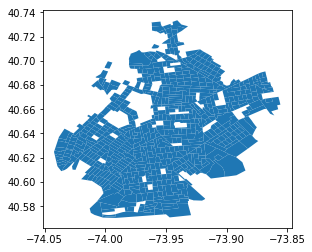

In [266]:
data.plot()

In [267]:
W = pysal.weights.Queen.from_dataframe(data)

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\pysal\weights\weights.py:189: UserWarning: There are 2 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\pysal\weights\weights.py:190: UserWarning: Island ids: 388, 476
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [268]:
W.islands

[388, 476]

In [269]:
data = data.drop(W.islands)

In [270]:
from pysal.spreg import ols

In [271]:
W1 = pysal.weights.Queen.from_dataframe(data)

In [272]:
lm_no_units = smf.ols(formula='NEW_FV_T_perSQFT_x~units+'+'+'.join(data.columns[-4:])
             ,data=data).fit()

In [273]:
y = np.array(data['NEW_FV_T_perSQFT_x'])

In [274]:
y.shape = (len(y),1)

In [275]:
X = np.array(data[list(data.columns[-4:])+['units']]).T

In [276]:
X = X.T

In [277]:
ls = ols.OLS(y, X, name_y = 'difference', name_x = list(data.columns[-6:-2])+['units'], name_ds = 'data')
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :        data
Weights matrix      :        None
Dependent Variable  :  difference                Number of Observations:         660
Mean dependent var  :      0.1646                Number of Variables   :           6
S.D. dependent var  :      0.0803                Degrees of Freedom    :         654
R-squared           :      0.0987
Adjusted R-squared  :      0.0918
Sum squared residual:       3.826                F-statistic           :     14.3194
Sigma-square        :       0.006                Prob(F-statistic)     :    2.55e-13
S.E. of regression  :       0.076                Log likelihood        :     763.097
Sigma-square ML     :       0.006                Akaike info criterion :   -1514.194
S.E of regression ML:      0.0761                Schwarz criterion     :   -1487.241

-----------------------------------------------------------------------------

In [278]:
pysal.Moran(ls.u, W1, two_tailed=False)

In [279]:
mi = pysal.Moran(ls.u, W1, two_tailed=False)
print('Observed I:', mi.I, '\nExpected I:', mi.EI, '\n   p-value:', mi.p_norm)

Observed I: 0.745983991053 
Expected I: -0.0015174506828528073 
   p-value: 0.0


In [281]:
from pysal.spreg import ml_lag, ml_error

In [284]:
spat_err = ml_lag.ML_Lag(y, X, W1, 
                             name_y = 'value', name_x = list(data.columns[-4:])+['units'], 
                             name_w='W1', name_ds='data')
print(spat_err.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :        data
Weights matrix      :          W1
Dependent Variable  :       value                Number of Observations:         660
Mean dependent var  :      0.1646                Number of Variables   :           7
S.D. dependent var  :      0.0803                Degrees of Freedom    :         653
Pseudo R-squared    :      0.8354
Spatial Pseudo R-squared:  0.2408
Sigma-square ML     :       0.001                Log likelihood        :    1225.531
S.E of regression   :       0.033                Akaike info criterion :   -2437.061
                                                 Schwarz criterion     :   -2405.615

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

C:\Users\sddz0\Anaconda2\envs\py36\lib\site-packages\scipy\optimize\_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
